In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [82]:
print(train.shape)
print(test.shape)

(567730, 83)
(243313, 82)


Training dataset contains 567730 rows(records) and 83 columns(features)

In [7]:
train['HasDetections'].value_counts()`

0    482571
1     85159
Name: HasDetections, dtype: int64

#### This is a binary classification problem. But this is an imbalanced dataset based on count of target 'HasDetections'. There are more no of values of '0 class' than '1 class' . approx -> (1:6 ratio)

In [6]:
## datatypes and no of missing values in each feature column
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567730 entries, 0 to 567729
Data columns (total 83 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   MachineIdentifier                                  567730 non-null  object 
 1   ProductName                                        567730 non-null  object 
 2   EngineVersion                                      567730 non-null  object 
 3   AppVersion                                         567730 non-null  object 
 4   AvSigVersion                                       567730 non-null  object 
 5   IsBeta                                             567730 non-null  int64  
 6   RtpStateBitfield                                   565573 non-null  float64
 7   IsSxsPassiveMode                                   567730 non-null  int64  
 8   DefaultBrowsersIdentifier                          29528 non-null   float6

Train dataset has 83 columns, among which "HasDetections" is target column. There are 30 columns with categorical data (non-numerical)

#### Missing Values Handling

About 44 features have missing values in them. we shall perform missing data analysis for each type of datatype seperately 

In [72]:
## missing value counts of categorical(object) types
a = train.dtypes[train.dtypes == 'object'].index
(train[a].isna().sum()/train.shape[0]).sort_values(ascending=False).head(10)

PuaMode                         0.999813
Census_ProcessorClass           0.996121
Census_InternalBatteryType      0.704557
SmartScreen                     0.365272
Census_PrimaryDiskTypeName      0.001457
Census_ChassisTypeName          0.000070
Census_PowerPlatformRoleName    0.000009
OsBuildLab                      0.000002
SkuEdition                      0.000000
Census_FlightRing               0.000000
dtype: float64

There are 8 columns of object dtype with missing values. "PuaMode" feature being with highest with almost 99% missing values.

In [73]:
## missing value counts of float types
b = train.dtypes[train.dtypes == 'float'].index
(train[b].isna().sum()/train.shape[0]).sort_values(ascending=False)

DefaultBrowsersIdentifier                            0.947989
Census_IsFlightingInternal                           0.827571
Census_ThresholdOptIn                                0.631275
Census_IsWIMBootEnabled                              0.630317
OrganizationIdentifier                               0.309818
SMode                                                0.067842
CityIdentifier                                       0.036826
Wdft_IsGamer                                         0.033347
Wdft_RegionIdentifier                                0.033347
Census_InternalBatteryNumberOfCharges                0.028239
Census_FirmwareManufacturerIdentifier                0.022759
Census_FirmwareVersionIdentifier                     0.019884
Census_IsFlightsDisabled                             0.017480
Census_OEMModelIdentifier                            0.011865
Census_OEMNameIdentifier                             0.011111
Firewall                                             0.010184
Census_T

There are 50 columns of float dtype having missing values. "DefaultBrowsersIdentifier" feature being with highest = 94.7% and "GeoNameIdentifier" with lowest -> 0.0032%

In [38]:
## missing value counts of int types
c = train.dtypes[train.dtypes == 'int64'].index
train[c].isna().sum().sort_values(ascending=False).head()

HasDetections        0
AutoSampleOptIn      0
IsSxsPassiveMode     0
HasTpm               0
CountryIdentifier    0
dtype: int64

As we can see, columns with int dtypes having no missing values. So we only have to deal with columns of object and float datatypes.

Two features "PuaMode", "Census_ProcessorClass" have about 99% missing values, meaning almost empty. It makes sense to drop these columns completely.

In [84]:
train.drop('PuaMode',inplace=True, axis=1)
train.drop('Census_ProcessorClass',inplace=True, axis=1)
test.drop('PuaMode', inplace=True, axis=1)
test.drop('Census_ProcessorClass', inplace=True, axis=1)

In [85]:
train["Census_InternalBatteryType"].value_counts()

lion        132394
li-i         15971
#            11383
lip           3816
liio          2154
li p           464
li             454
nimh           329
bq20           207
real           177
vbox           151
pbac           108
unkn            43
lgi0            25
lhp0            15
4cel             9
lipo             8
ithi             4
lipp             4
virt             3
batt             3
pad0             3
ots0             2
#TAB#            1
ca48             1
8                1
l&#TAB#         1
li-p             1
Name: Census_InternalBatteryType, dtype: int64

Because of the presence of vague values in Battery_type_column, & for the sake of simplicity, lets club other than lion batteries into another value - 'non-lion' since most modern batteries are lithium lion based. This will also eventually fill the missing values.

In [90]:
## filling values with lion as 1 as others as 0, same change reflected in test dataset
def filter_batteries(bat):
    bat = str(bat)
    if 'li' in bat:
        return 1
    else:
        return 0

train["Census_InternalBatteryType"] = train["Census_InternalBatteryType"].apply(filter_batteries)
test["Census_InternalBatteryType"] = test["Census_InternalBatteryType"].apply(filter_batteries)

In [94]:
train['SmartScreen'].value_counts()

RequireAdmin    298936
ExistsNotSet     37910
Off              11932
Warn              7676
Prompt            2288
Block             1432
off                 75
On                  52
&#x02;              26
&#x01;              15
on                   9
OFF                  2
requireadmin         1
Name: SmartScreen, dtype: int64

Similar situation arises in Smart_Screen feature, but here the values are repeated in different form of words, so we need to clean whichever have special chars and convert similar words to single root form

In [95]:
conversion_dict = {
    'off': 'Off', '&#x02;': '2', '&#x01;': '1', 'on': 'On', 'requireadmin': 'RequireAdmin', 'OFF': 'Off', 
    'Promt': 'Prompt', 'requireAdmin': 'RequireAdmin', 'prompt': 'Prompt', 'warn': 'Warn', 
    '00000000': '0', '&#x03;': '3', np.nan: 'NoExist'
}
train.replace({'SmartScreen': conversion_dict}, inplace=True)
test.replace({'SmartScreen': conversion_dict}, inplace=True)

For features "Smart_screen", "Disk_Type", "Chassis_Type", "PowerPlatformRole", "OSBuild_Lab", we shall fill mode value for missing values in these. The reasoning is that people use computer parts that are most popular / or used by majority people.

In [97]:
for column in ['SmartScreen', 'Census_PrimaryDiskTypeName', 'Census_ChassisTypeName', 'Census_PowerPlatformRoleName', 'OsBuildLab']:
    train[column].fillna(train[column].mode()[0], inplace=True)
    test[column].fillna(test[column].mode()[0], inplace=True)

We shall fill remaining columns of float dtype with mode values too for now to make it easier for EDA Analysis. Later we can change if required in Feature Engineering.

In [103]:
for feature in ["DefaultBrowsersIdentifier", "Census_IsFlightingInternal", "Census_ThresholdOptIn", "Census_IsWIMBootEnabled", "OrganizationIdentifier", "SMode", "CityIdentifier", "Wdft_IsGamer", "Wdft_RegionIdentifier", "Census_InternalBatteryNumberOfCharges", "Census_FirmwareManufacturerIdentifier", "Census_FirmwareVersionIdentifier", "Census_IsFlightsDisabled", "Census_OEMModelIdentifier", "Census_OEMNameIdentifier", "Firewall", "Census_TotalPhysicalRAM", "Census_IsAlwaysOnAlwaysConnectedCapable", "Census_OSInstallLanguageIdentifier", "IeVerIdentifier", "Census_SystemVolumeTotalCapacity", "Census_PrimaryDiskTotalCapacity", "Census_InternalPrimaryDiagonalDisplaySizeInInches", "Census_InternalPrimaryDisplayResolutionHorizontal", "Census_InternalPrimaryDisplayResolutionVertical", "AVProductsEnabled", "AVProductsInstalled", "AVProductStatesIdentifier", "IsProtected", "Census_ProcessorModelIdentifier", "Census_ProcessorCoreCount", "Census_ProcessorManufacturerIdentifier", "RtpStateBitfield", "Census_IsVirtualDevice", "UacLuaenable", "GeoNameIdentifier"]:
    train[feature].fillna(train[feature].mode()[0], inplace=True)
    test[feature].fillna(test[feature].mode()[0], inplace=True)

### Skew Analysis

Skew parameter of each feature column:

In [114]:
#train.skew(axis=0, skipna=True).sort_values(ascending = True)

sk = pd.DataFrame([{'column': c, 'skew': train[c].value_counts(normalize=True).values[0] * 100} for c in train.columns])
sk.sort_values(by='skew', ascending=False).head(20)

,column,skew
73,Census_IsWIMBootEnabled,100.000000
66,Census_IsFlightingInternal,99.999824
5,IsBeta,99.999295
67,Census_IsFlightsDisabled,99.998239
27,AutoSampleOptIn,99.997182
69,Census_ThresholdOptIn,99.990488
63,Census_IsPortableOperatingSystem,99.953323
28,SMode,99.935885
34,Census_DeviceFamily,99.815053
32,UacLuaenable,99.402533


As we can see some features are have very large skewness. Some of them have almost 99% skew in them, meanining almost all values are of only few categories. This high skew features won't help much for learning algorithm since it won't add much info to learning. Hence, we shall drop these skewed columns (skew > 99%) from dataset. 

In [122]:
skewed_features = ["Census_IsWIMBootEnabled", "Census_IsFlightingInternal", "IsBeta", "Census_IsFlightsDisabled", "AutoSampleOptIn", "Census_ThresholdOptIn", "Census_IsPortableOperatingSystem", "SMode", "Census_DeviceFamily", "UacLuaenable", "Census_IsVirtualDevice", "ProductName"]
train.drop(skewed_features, axis=1, inplace=True)
test.drop(skewed_features, axis=1, inplace=True)

### EDA Analysis

### Univariate Analysis

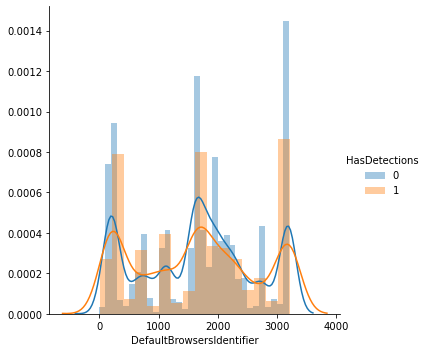

In [13]:
sns.FacetGrid(train, hue="HasDetections", height = 5).map(sns.distplot, "DefaultBrowsersIdentifier").add_legend()
plt.show()

In [21]:
train["DefaultBrowsersIdentifier"].describe()

count    29528.000000
mean      1662.358169
std        985.986807
min          1.000000
25%        788.000000
50%       1632.000000
75%       2290.000000
max       3209.000000
Name: DefaultBrowsersIdentifier, dtype: float64

In [70]:
train["HasTpm"].value_counts()

1    560694
0      7036
Name: HasTpm, dtype: int64